### Вариант 1

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import scipy.stats as sp
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

pd.options.mode.chained_assignment = None
%matplotlib inline

from tqdm.auto import tqdm
from scipy.stats import norm
plt.style.use('seaborn-whitegrid')

sns.set(font_scale = 1.25,
        style = 'whitegrid',
        rc = {'figure.figsize': (14, 3)})

#### *Задание 1*
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [2]:
# Выгрузка данных
reg_data = pd.read_csv('C:/Users/anyur/problem1-reg_data.csv', sep = ';')
aug_data = pd.read_csv('C:/Users/anyur/problem1-auth_data.csv', sep = ';')

In [3]:
reg_data.head(3)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3


In [4]:
aug_data.head(3)

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2


In [5]:
# приведем время в читаемый вид
reg_data['reg_ts'] = pd.to_datetime(reg_data.reg_ts, unit = 's')
aug_data['auth_ts'] = pd.to_datetime(aug_data.auth_ts, unit = 's')

In [6]:
# переименуем переменные
reg_data.rename(columns = {'reg_ts': 'registration_date', 'uid': 'id'}, inplace = True)
aug_data.rename(columns = {'auth_ts': 'authorization_date', 'uid': 'id'}, inplace = True)

В задании указано считать retention по дням, но, как мне кажется, за большой период времени осмысленнее считать по неделям - если количество дней превышает +- 50, делать какие то выводы при подсчете по дням затруднительно. Поэтому, если число указанных дней в параметре period_in_days превышает 50, функция будет считать retention по неделям вне зависимости от аргумента way.

In [24]:
def retention_by_cohort(reg_data, # данные о дате и времени регистрации и id
                        aug_data, # данные о дате и времени авторизации и id
                        period_in_days = 14, # аргумент, фиксирующий количество дней, за которые будет считаться retention
                        way = 'days' # {'days', 'weeks'} - способ подсчета retention (по дням или по неделям)
):
    
    # мёрджим данные
    df = aug_data.merge(reg_data, on = 'id', how = 'left')
    df = df[['id', 'registration_date', 'authorization_date']]
    
    # оставляем только данные за то кол-во дней, которое указано в аргументе period_in_days
    days = dt.timedelta(days = period_in_days)
    margin_date = df['registration_date'].max() - days
    margin_date = margin_date.replace(hour = 0, minute = 0, second = 0)
    df = df[df['registration_date'] > margin_date]
 
    # условная конструкция для выбора способа подсчета retention (дни или недели) и создания осей X и Y
    if way == 'weeks' or period_in_days > 50:
        week_diff = df['authorization_date'].dt.isocalendar().week - df['registration_date'].dt.isocalendar().week
        df['time'] = week_diff + 1
        df['cohort'] = df['registration_date'].dt.to_period('W')
    else:
        month_diff = df['authorization_date'].dt.month - df['registration_date'].dt.month
        days_diff = df['authorization_date'].dt.day - df['registration_date'].dt.day
        df['time'] = month_diff * 30 + days_diff + 1
        df['cohort'] = df['registration_date'].dt.date 
        
    # группируем по когорте и периодом времени между регистрацией и авторизацией, агрегируем по уникальным id
    cohort_data = df.groupby(['cohort', 'time'], as_index = False).agg({'id': pd.Series.nunique})
    
    # делаем сводную таблицу
    cohort_count = cohort_data.pivot_table(index = 'cohort', columns = 'time', values = 'id')
    
    # переводим retention в проценты
    cohort_size = cohort_count.iloc[:, 0]
    retention = cohort_count.divide(cohort_size, axis = 0)
    
    # визуализируем
    plt.figure(figsize = (22, 11))
    plt.title('Cohort Analysis - Retention Rate')
    sns.heatmap(data = retention, 
                annot = True, 
                fmt = '.0%', 
                vmin = 0.0,
                vmax = 0.5,
                cmap = "YlGnBu")
    plt.show()

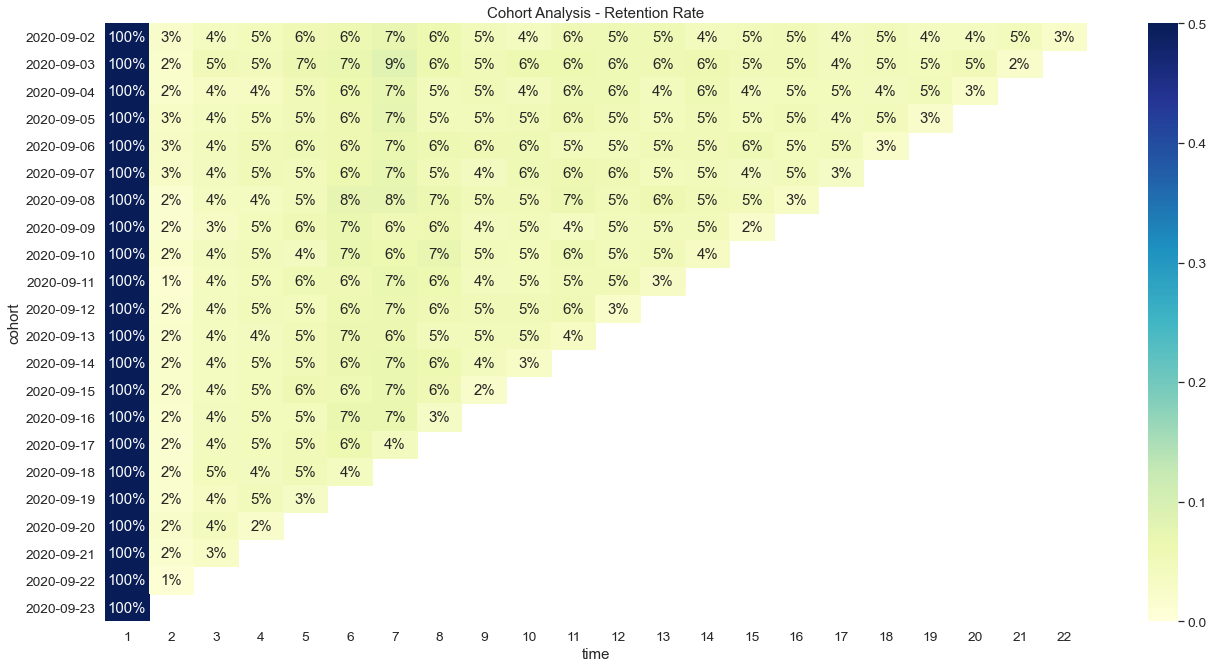

In [8]:
# пример работы функции для 21 дня, подсчет retention по дням
retention_by_cohort(reg_data, aug_data, period_in_days = 21, way = 'days')

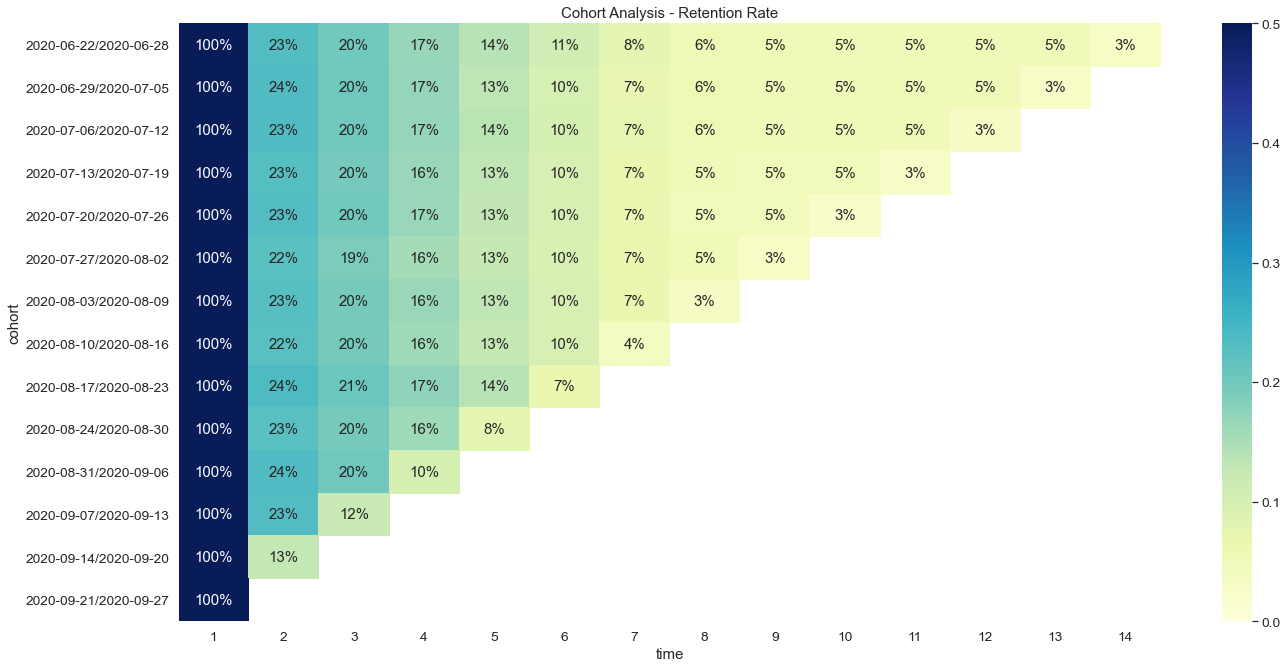

In [25]:
# пример работы функции для 90 дней, подсчет retention по неделям
retention_by_cohort(reg_data, aug_data, period_in_days = 90, way = 'weeks')

--------------------------

#### *Задание 2*
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [10]:
df = pd.read_csv('C:/Users/anyur/problem2.csv', sep = ';')

In [11]:
df.head(3)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a


In [12]:
df.dtypes

user_id       int64
revenue       int64
testgroup    object
dtype: object

In [13]:
print('Кол-во платящих пользователей в контрольной группе:', df.query('testgroup == "a" & revenue > 0').shape[0])
print('Кол-во платящих пользователей в тестовой группе:', df.query('testgroup == "b" & revenue > 0').shape[0])

Кол-во платящих пользователей в контрольной группе: 1928
Кол-во платящих пользователей в тестовой группе: 1805


In [14]:
# конверсия в покупку для контрольной группы
np.round(df.query('revenue > 0 & testgroup == "a"').shape[0] / df.query('testgroup == "a"').shape[0] * 100, 2)

0.95

In [15]:
# конверсия в покупку для тестовой группы
np.round(df.query('revenue > 0 & testgroup == "b"').shape[0] / df.query('testgroup == "b"').shape[0] * 100, 2)

0.89

In [16]:
# ARPU по группам
df.groupby('testgroup', as_index = False) \
    .agg({'revenue': 'mean'}) \
    .rename(columns = {'revenue': 'ARPU', 'testgroup': 'group'})

,group,ARPU
0,a,25.413720
1,b,26.751287


In [17]:
# ARPPU по группам
df.query('revenue > 0') \
    .groupby('testgroup', as_index = False) \
    .agg({'revenue': 'mean'}) \
    .rename(columns = {'revenue': 'ARPPU', 'testgroup': 'group'})

,group,ARPPU
0,a,2663.998444
1,b,3003.658172


Что имеем: конверсия в покупку в тестовой группе меньше, зато ARPU и ARPPU больше. Говоря простыми словами, в тестовой группе люди совершают меньше покупок, но оставляют больше денег. Для принятия верного продуктового решения необходимо проверить эти утверждения, т.е ответить на следующие вопросы:
1) Действительно ли в тестовой группе люди покупают *статистически значимо* меньше, или это случайность и при проведении повторного эксперимента все могло бы быть иначе?

2) Действительно ли в тестовой группе люди тратят *статистически значимо* больше, или это также случайность?

Ответим на первый вопрос. Для этого немного изменим наши данные, сделав из количественной переменной revenue дамми-переменную purchase, фиксирующую факт совершения покупки. Это позволит проверить гипотезу о наличии статистически значимых различий в показателях конверсии в покупку между двумя группами. 

In [18]:
control_conversion = np.where(df.query('testgroup == "a"')['revenue'] > 0, 1, 0)
control_conversion = pd.DataFrame({'purchase': control_conversion})

In [19]:
test_conversion = np.where(df.query('testgroup == "b"')['revenue'] > 0, 1, 0)
test_conversion = pd.DataFrame({'purchase': test_conversion})

В итоге получаем два распределения Бернулли, средние которых равны показателям конверсии для контрольной и тестовой групп. 

In [20]:
control_conversion.mean() * 100

purchase    0.953969
dtype: float64

In [21]:
test_conversion.mean() * 100

purchase    0.890624
dtype: float64

Исходя из этого, мы можем сформулировать статистические гипотезы следующим образом:

*Нулевая гипотеза:* средние значения двух генеральных совокупностей, откуда взяты выборки, равны, или $H_0: conversion_c=conversion_t$.

*Альтернативная гипотеза:* средние значения двух генеральных совокупностей не равны, или:  $H_1: conversion_c \ne conversion_t$

Для проверки гипотез будем использовать бутстреп со средним.

In [22]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.vlines(ci, ymin = 0, ymax = 50, linestyle = '--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/10000 [00:00<?, ?it/s]

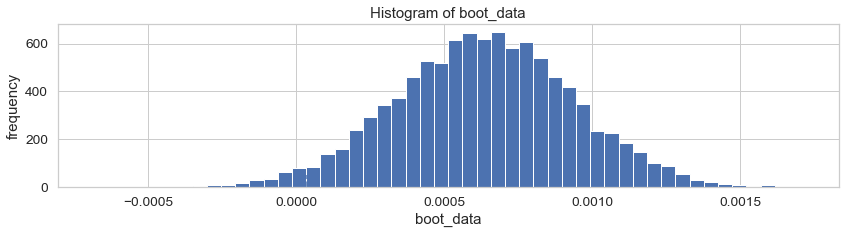

p-value is: 0.0348


In [23]:
booted_data = get_bootstrap(control_conversion['purchase'], test_conversion['purchase'], boot_it = 10000, statistic = np.mean)
print('p-value is:', booted_data['p_value'].round(4))

Вывод: конверсия в покупку в тестовой группе статистически значимо меньше, чем в контрольной (на уровне стат. значимости 0.05).

Теперь мы можем ответить на второй вопрос - действительно ли в тестовой группе люди тратят статистически значимо больше? 
Для этого отберем только тех, кто совершил оплату, и посмотрим на распределения.

In [26]:
control_arppu = df.query('testgroup == "a" & revenue > 0')['revenue']

In [27]:
test_arppu = df.query('testgroup == "b" & revenue > 0')['revenue']

<AxesSubplot:xlabel='revenue', ylabel='Count'>

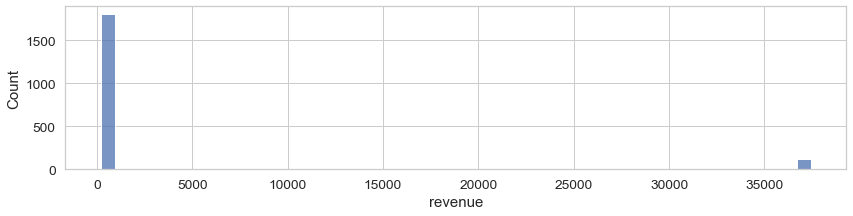

In [28]:
sns.histplot(data = control_arppu, bins = 50)

<AxesSubplot:xlabel='revenue', ylabel='Count'>

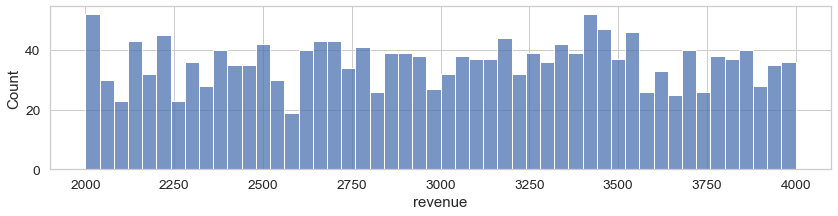

In [29]:
sns.histplot(data = test_arppu, bins = 50)

Значения в тестовой группе распределены более менее равномерно, а в контрольной группе имеются сильные выбросы. Будем исходить из того, что эти выбросы в контрольной группе не случайны и имеют закономерный характер. Это утверждение спорно - вполне возможно, что эти выбросы являются результатом технических проблем или проблем с системой сплитования, но на имеющихся данных доказать это невозможно, поэтому оставим их и воспользуемся бутстрепом с медианой для проврки следующих статистических гипотез:

*Нулевая гипотеза:* медианные значения двух генеральных совокупностей, откуда взяты выборки, равны, или $H_0: M_c=M_t$.

*Альтернативная гипотеза:* медианные значения двух генеральных совокупностей не равны, или:  $H_1: M_c \ne M_t$

Важно отметить, что средние значения в контрольной и тестовой группах, состоящих только из заплативших пользователей, равны показателеям ARPPU для этих групп.

In [30]:
control_arppu.mean()

2663.9984439834025

In [31]:
test_arppu.mean()

3003.6581717451522

Получается, что в сущности мы проверяем гипотезы о равенстве показателей ARPPU в двух ген. совокупностях, из которых взяты выборки.

  0%|          | 0/10000 [00:00<?, ?it/s]

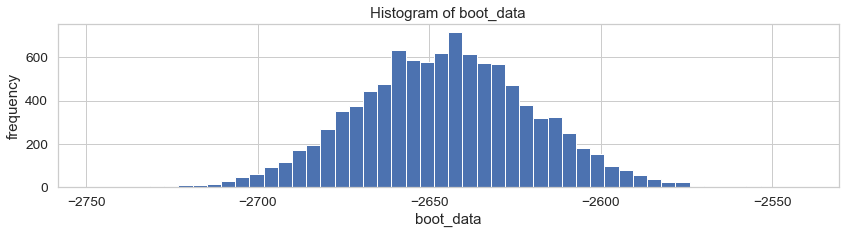

p-value is: 0.0


In [32]:
booted_data = get_bootstrap(control_arppu, test_arppu, boot_it = 10000, statistic = np.median)
print('p-value is:', booted_data['p_value'].round(4))

Вывод: ARPPU в тестовой группе статистически значимо выше, чем в контрольной (на всех конвенциональных уровнях стат. значисмости).

Кроме того, бутстреп позволяет проверить не только гипотезы о равенстве медиан, но и равенстве каждого дециля двух распределений. Это может помочь понять, где именно распределения отличаются сильней всего.

In [33]:
def get_bootstrap_deciles(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 3000, # количество бутстрэп-подвыборок
    statistic = np.quantile, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):

    boot_len = max([len(data_column_1), len(data_column_2)]) # размер бутстрэп-подвыборок
    intervals = [] # доверительные интервалы
    sample_means = [] # средние бутстрэп распределения разниц
    quantile = 0.1 # интересующая статитстика
    p_values = [] # p-values для квантилей в выборках
    pbar = tqdm(total = 100)
    
    while quantile < 0.9:
        pbar.update(11)
        
        # наберем 3000 бутвыборок для обеих выборок и сравним их квантили
        boot_params = []
        for i in range(boot_it):
            boot_sample_1 = data_column_1.sample(boot_len, replace = True).values
            boot_sample_2 = data_column_2.sample(boot_len, replace = True).values
            a = np.quantile((boot_sample_1), quantile)
            b = np.quantile((boot_sample_2), quantile)
            diff = b - a
            boot_params.append(diff)

        # посчитаем доверительный интервал перцентильным методом
        boot_conf_level = 0.95
        left_ci = (1 - boot_conf_level) / 2
        right_ci = 1 - (1 - boot_conf_level) / 2
        ci_l = pd.Series(boot_params).quantile(left_ci)
        ci_r = pd.Series(boot_params).quantile(right_ci)
        ci = (ci_l.round(2), ci_r.round(2))
        intervals.append(ci)
        
        # считаем вероятности получить такие отклонения среднего бут-распределения от 0 случайно
        p_1 = norm.cdf( x = 0, loc = np.mean(boot_params), scale = np.std(boot_params))
        p_2 = norm.cdf( x = 0, loc = -np.mean(boot_params), scale = np.std(boot_params))
        p_value = min(p_1, p_2) * 2
        p_values.append(p_value.round(2))
        sample_means.append(np.mean(boot_params).round(2))
        
        # перейдем к следующему децилю
        quantile += 0.1
        
    pbar.update(1)
    pbar.close()
    
    df = pd.DataFrame({'confidence interval': intervals, 'mean': sample_means, 'p-value': p_values})
    
    # визуализация
    plt.figure(figsize = (8, 4))
    plt.errorbar(x = np.arange(1, 10, 1), y = sample_means, yerr = [(top - bot) / 2 for top, bot in intervals],
                 color = 'black', ls = '--', marker = 'o', capsize = 5, capthick = 1, ecolor = 'black')
    plt.hlines(xmin = 1, xmax = 9, y = 0, linewidth = 2.5, color = "#C32D6B")
    plt.xlabel('Децили')
    plt.ylabel('Разница децилей')
    plt.show()
    
    return {'data': df}

  0%|          | 0/100 [00:00<?, ?it/s]

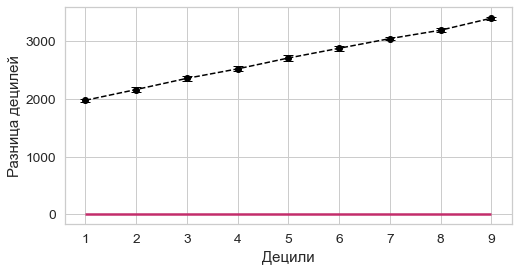

In [34]:
bootstrap_deciles = get_bootstrap_deciles(control_arppu, test_arppu, boot_it = 3000)

In [35]:
bootstrap_deciles['data']

,confidence interval,mean,p-value
0,"(1949.8, 2003.7)",1978.96,0.0
1,"(2129.0, 2204.4)",2165.08,0.0
2,"(2315.3, 2392.0)",2358.81,0.0
3,"(2483.0, 2571.02)",2523.21,0.0
4,"(2657.0, 2761.0)",2711.14,0.0
5,"(2839.0, 2921.0)",2879.90,0.0
6,"(3013.78, 3076.9)",3047.28,0.0
7,"(3159.0, 3237.6)",3192.95,0.0
8,"(3374.2, 3424.7)",3401.15,0.0


Различия значимы для каждого дециля.

Итак, на данный момент мы выяснили, что конверсия в покупку в контрольной группе статистически значимо больше, чем в тестовой. Также мы выяснили, что ARPPU в тестовой группе статистически значимо выше, чем в контрольной. Осталось проверить, есть ли статистически значимые различия в ARPU. 

Посмотрим на распределения.

<AxesSubplot:xlabel='revenue', ylabel='Count'>

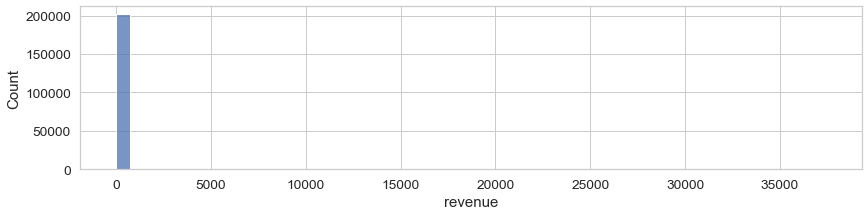

In [36]:
sns.histplot(data = df.query('testgroup == "a"')['revenue'], bins = 50)

<AxesSubplot:xlabel='revenue', ylabel='Count'>

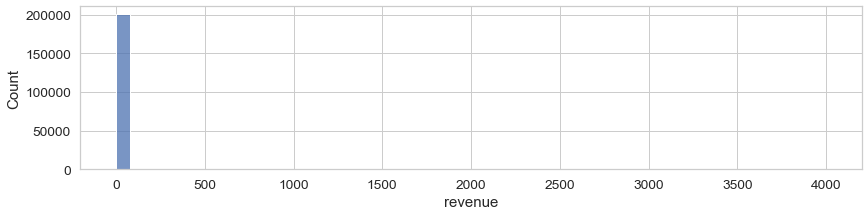

In [37]:
sns.histplot(data = df.query('testgroup == "b"')['revenue'], bins = 50)

Большинство полизователей в обеих группах - неплатящие, поэтому оба распределения скошены. Т-тест и бутстреп со средним тут не помогут, так как среднее - нерепрезентативный параметр для таких распределений. Бутстреп с медианой также не подойдет, поскольку большая часть значений - нули, которые будут попадать в медианное значение. Воспользуемся критерием Мана-Уитни, который проверяет нулевую гипотезу о равенстве распределений и может работать с такими данными.

In [38]:
sp.mannwhitneyu(df.query('testgroup == "a"')['revenue'], df.query('testgroup == "b"')['revenue'])

MannwhitneyuResult(statistic=20468349325.0, pvalue=0.03134850658037196)

Вывод: ARPU в тестовой группе статистически значимо выше, чем в контрольной (на уровне стат. значисмости 0.05)

### Выводы

Мы проанализировали такие метрики как конверсия в покупку, ARPU и ARPPU и выяснили, что конверсия статистически значимо больше в контрольной группе, а ARPU и ARPPU - в тестовой. Окончательное решение о том, какой набор предложений можно считать лучшим, зависит от того, какие метрики мы рассматриваем в качестве целевых - если это конверсия, то лучше оставить набор акционных предложений из контрольной группы, если же это ARPU и/или ARPPU, то из тестовой. 

В то же время стоит отметить, что выбросы в контрольной группе (пользователи с revenue > 30.000) выглядят крайне подозрительно, и могут намекать на наличие технических проблем при сборе данных или багов в системе сплитования. Поэтому, прежде чем принимать окончательное продуктовое решение, необходимо проверить данные на валидность.

----------------------------

#### *Задание 3*

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

#### Ответ: 
Прежде всего, необходимо отслеживать DAU и ACU и сравнивать показатели этих метрик до/во время/после проведения тематических событий. Исходя из здравого смысла, во время проведения каких-либо ивентов DAU и ACU должны расти, и, если ивент смог стимулировать азарт игроков, после ивента DAU и ACU будут оставаться немного выше, чем avg_DAU и avg_ACU до ивента. Плохой сценарий - если DAU и ACU растут во время ивента и сильно проседают после - это может говорить о том, что игроки получили все что хотели и частично утратили интерес к игре. Таким образом, сравнение DAU и ACU в период до/во время/после ивента может помочь отследить "остаточный эффект" - если он положительный, драйв и азарт будут приводить пользователей в игру и после ивента, а если он отрицательный - игроки утратят интерес и перестанут заходить в игру. 

Кроме того, "остаточный эффект" можно оценивать превентивно - ввести метрику "коэффициент обогащения", которая будет фиксировать отношение уникальных предметов, дополнительных монет и бонусов, полученных во время ивента к тому, сколько игроки в среднем получают за тот же период времени в обычные дни. Если он будет слишком большим, это будет намекать на возможность "пресыщения" игроков и опасность их последующиего выгорания и низкой активности - напротив, слишком низкий коэф. обогащения будет говорить о том, что ивент, вероятно, не вызывает эмоционального отклика у игроков. Определить, какие показатели являются низкими, а какие высокими, получится только эмпирически, поэтому потребуется время и несколько проведенных ивентов для понимания того, на какие показатели стоит ориентироваться.  

В целом, коэф. обогащения должен быть одной из ключевых метрик - но для управления этой метрикой необходимо понимать, какие именно предметы/монеты/бонусы имеют наибольший спрос среди игроков, т.к обогащение предметами с высоким и низким спросом - концептуально различные типы обогащения, которые могут вызывать неодинаковые поведенческие реакции со стороны игроков. Поэтому необходимо отслеживать метрики "желанности" тех или иных предметов/монет/бонусов, соблюдая умеренный дисбаланс спроса и предложения и не позволяя игрокам получить слишком много или слишком мало. 

В то же время, будет полезно отслеживать такие метрики как среднее кол-во игровых сессий, средняя длина игровой сессии и общее ежедневное время игры. Успешное тематическое событие будет бустить эти метрики. ARPU и ARPPU - также должны находиться в поле зрения, поскольку являются ключевыми метриками, на основании которых можно судить о финансовой выгодности ивента (хотя, если ивент направлен на количественное увеличение аудитории, а не на рост ARPU/ARPPU, то эти метрики могут оказаться второстепенными).

Усложнение механики событий введением возможности отката на несколько уровней назад - рискованная затея. В этой ситуации все вышеописанные метрики также останутся релевантными, но появится возможность осветить ивент и с других сторон. В первую очередь, будет необходимо отслеживать соотношение успешных/неуспешных попыток пройти уровень. Условно говоря, если соотношение 1 к 100 - игроки, несомненно, будут фрустрированы и вряд ли захотят оставаться активными - напротив, соотношение 99 к 100 будет стимулировать не азарт и задор, а скуку, что также крайне нежелательно. 

Помимо этого, надежным индикатором обоснованности усложнения механики событий может служить FUUU метрика, которая может рассчитываться как отношение тех, кто покинул игру после отката на предыдущий уровень к тем, кто продолжил играть. Предпочтительно, чтобы показатель этой метрики стремился к нулю - обратное будет свидетельствовать о том, что усложненная механика повышает Churn Rate. 

Также, конечно, будет полезно смотреть Churn Rate в разрезе уровней игры - на каких уровнях большинство людей покидает игру, т.к это поможет обнаружить самые сложные уровни, бустящие FUUU метрику. 